In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection, preprocessing, metrics, dummy, linear_model, ensemble
from xgboost import XGBClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor
import shap

## Part 1

## Data Wrangling

In [2]:
#load the data and insepect the first few rows

path = 'data/data_science_assignment.csv'

df = pd.read_csv(path)

df.head()

,Success,Model_B,Date,X1,X2,X3,X4
0,0,0.320440,2018-07,0,-0.897088,0.804294,0.707665
1,0,0.491581,2018-09,1,-0.328084,-0.332256,-0.340870
2,0,0.085481,2015-08,0,1.272140,2.243532,0.815581
3,1,0.839927,2017-07,1,0.290594,-1.161187,-0.881761
4,0,0.146804,2018-09,0,-0.307462,1.161276,1.597084


In [3]:
#check for nulls and inspect data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Success  6000 non-null   int64  
 1   Model_B  6000 non-null   float64
 2   Date     6000 non-null   object 
 3   X1       6000 non-null   int64  
 4   X2       6000 non-null   float64
 5   X3       6000 non-null   float64
 6   X4       6000 non-null   float64
dtypes: float64(4), int64(2), object(1)
memory usage: 328.2+ KB


In [4]:
#convert the Date field from object to datetime
df.Date = pd.to_datetime(df.Date)

In [5]:
#inspect value ranges, summary stats
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Success,6000.0,0.155667,0.362569,0.000000,0.000000,0.000000,0.000000,1.000000
Model_B,6000.0,0.493951,0.209031,0.021030,0.330084,0.491583,0.657086,0.988474
X1,6000.0,0.502167,0.500037,0.000000,0.000000,1.000000,1.000000,1.000000
X2,6000.0,-0.003326,1.004197,-3.612620,-0.702663,-0.001634,0.685290,3.896294
X3,6000.0,0.007374,1.012626,-4.860280,-0.673058,0.015458,0.681624,3.852129
X4,6000.0,0.015992,1.013181,-4.416066,-0.662022,0.020163,0.681972,3.641890


0    0.844333
1    0.155667
Name: Success, dtype: float64

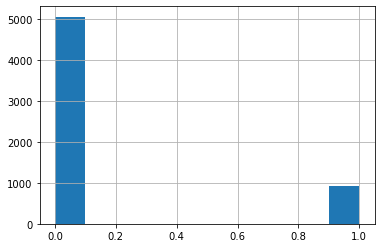

In [6]:
#the Success field appears skewed (most campaigns appear ineffective)
df.Success.hist();
df.Success.value_counts(normalize=True)

The classes are imbalanced but the imbalance is insignificant enough that it is likely unnecessary to take special steps (such as under or oversampling) to address the imbalance.

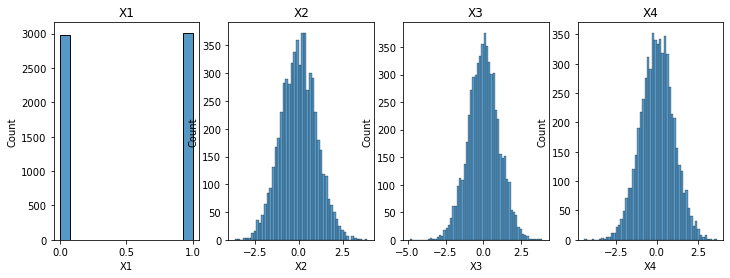

In [7]:
#inspect the distributions for the new features (X1 - X4)
features = ['X' + str(i) for i in range(1,5)]

fig, ax = plt.subplots(1,4, figsize=(12,4))

for i, feature in enumerate(features):
    sns.histplot(data = df, x = feature, ax=ax.flatten()[i])
    ax.flatten()[i].set_title(feature)

X1's values are distrubted evenly between 0 and 1.

X2 - X4 all appear normally distributed with their mean centred around 0. 

There do not appear to be any significant outliers.

## Exploratory Data Analysis

In [8]:
#overall success rate
success_rate = df['Success'].sum()/df['Success'].count()
success_rate

0.15566666666666668

**Relationships between predictors (X1-X4) and the target feature (Success)**

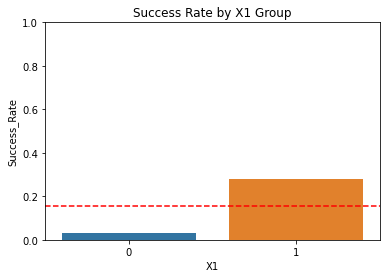

In [9]:
#X1

#group the data by X1
df_success_X1 = df.groupby('X1').agg({'Success':'sum', 'Model_B':'count'}) \
    .reset_index() \
    .rename(columns={'Model_B':'Count'})

#calculate success rates
df_success_X1['Success_Rate'] = df_success_X1.Success / df_success_X1.Count


#inspect the different success rates
sns.barplot(x='X1', y='Success_Rate', data=df_success_X1);
plt.gca().set(ylim=(0,1));
plt.gca().set_title('Success Rate by X1 Group')

#plot the overall success rate
plt.gca().axhline(success_rate, linestyle='--', color='red');

Success rate tends to be much higher when X1 is true.

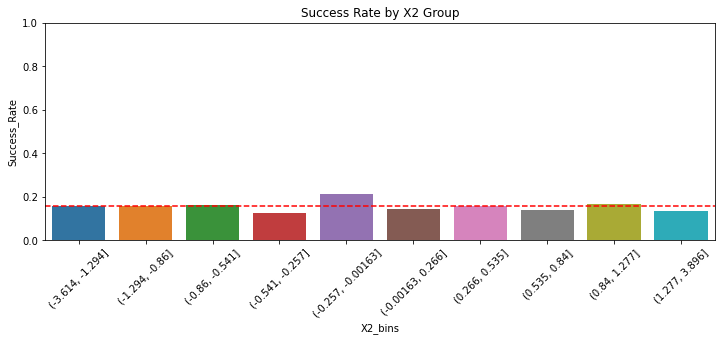

In [10]:
#X2

#bin the X2 data for analysis
df['X2_bins'] = pd.qcut(df['X2'],10)

#group the data by X2 bins
df_success_X2 = df.groupby('X2_bins').agg({'Success':'sum', 'Model_B':'count'}) \
    .reset_index() \
    .rename(columns={'Model_B':'Count'})

#calculate success rates
df_success_X2['Success_Rate'] = df_success_X2.Success / df_success_X2.Count

#plot the success rate by X2 range
plt.subplots(figsize=(12,4))
sns.barplot(x='X2_bins', y='Success_Rate', data=df_success_X2);
plt.gca().set(ylim=(0,1));
plt.gca().set_title('Success Rate by X2 Group')
for label in plt.gca().get_xticklabels():
        label.set_rotation(45) 
        
#plot the overall success rate
plt.gca().axhline(success_rate, linestyle='--', color='red');

#drop the temporary X2_bins feature
df.drop(columns=['X2_bins'], inplace=True)

X2 does not appear to have a significant impact on success rate. However, for now we can keep X2 as we can not know for sure that it will not be beneficial during the modeling stage.

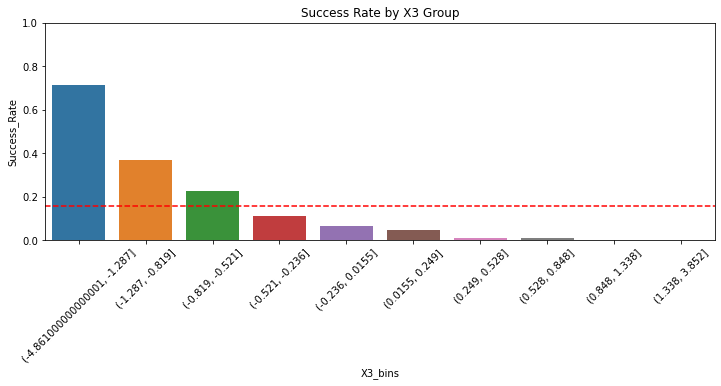

In [11]:
#X3

#bin the X3 data for analysis
df['X3_bins'] = pd.qcut(df['X3'],10)

#group the data by X3 bins
df_success_X3 = df.groupby('X3_bins').agg({'Success':'sum', 'Model_B':'count'}) \
    .reset_index() \
    .rename(columns={'Model_B':'Count'})

#calculate success rates
df_success_X3['Success_Rate'] = df_success_X3.Success / df_success_X3.Count

#plot the success rate by X3 range
plt.subplots(figsize=(12,4))
sns.barplot(x='X3_bins', y='Success_Rate', data=df_success_X3);
plt.gca().set(ylim=(0,1));
plt.gca().set_title('Success Rate by X3 Group')
for label in plt.gca().get_xticklabels():
        label.set_rotation(45) 
        
#plot the overall success rate
plt.gca().axhline(success_rate, linestyle='--', color='red');

#drop the temporary X3_bins feature
df.drop(columns=['X3_bins'], inplace=True)

X3 appears to be a useful feature for predicting success. The success rate is much higher at lower X3 levels

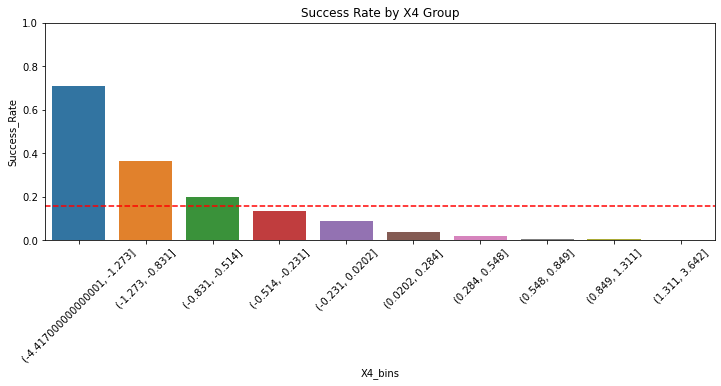

In [12]:
#X4

#bin the X4 data for analysis
df['X4_bins'] = pd.qcut(df['X4'],10)

#group the data by X4 bins
df_success_X4 = df.groupby('X4_bins').agg({'Success':'sum', 'Model_B':'count'}) \
    .reset_index() \
    .rename(columns={'Model_B':'Count'})

#calculate success rates
df_success_X4['Success_Rate'] = df_success_X4.Success / df_success_X4.Count

#plot the success rate by X4 range
plt.subplots(figsize=(12,4))
sns.barplot(x='X4_bins', y='Success_Rate', data=df_success_X4);
plt.gca().set(ylim=(0,1));
plt.gca().set_title('Success Rate by X4 Group')
for label in plt.gca().get_xticklabels():
        label.set_rotation(45) 
        
#plot the overall success rate
plt.gca().axhline(success_rate, linestyle='--', color='red');

#drop the temporary X4_bins feature
df.drop(columns=['X4_bins'], inplace=True)

X4 appears to be a useful feature for predicting success. The success rate is much higher at lower X4 levels. However the X3 and X4 trends appear very similar so it is likely worth check for multicollinearity in order to remove redundant features.

## Correlation Heatmap

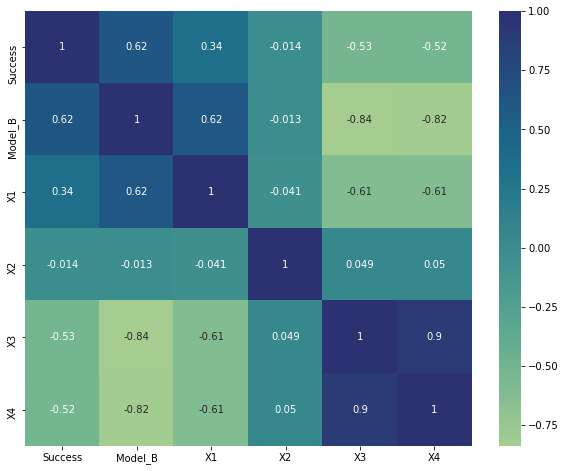

In [13]:
#heatmap to inspect correlations 
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), cmap='crest', annot=True);

The correlation heatmap agrees with the above analysis:
* X1, X3, and X4 all have a large enough (positive or negative) correlation with Success that we can expect reasonable predictive power
* X2 has much lower correlation with Success and likely won't have much predictive power
* X3 and X4 are highly correlated and likely redundant - one of these features will likely be removed when multicollinear features are filtered out. Another option would be to combine these two features into a single feature.
* X1 also has a moderately strong (negative) correlation with X3 and X4.

## Feature Engineering

**It appears that we only have date data at a monthly granularity. Therefore, data cannot be inspected at a finer grained level than the month**

In [14]:
#check the day of the month
df.Date.dt.day.value_counts()

1    6000
Name: Date, dtype: int64

**We can derive the month of the year from the date to inspect seasonality**

In [15]:
#month
df['month'] = df.Date.dt.month
df.month

0        7
1        9
2        8
3        7
4        9
        ..
5995     2
5996    11
5997     4
5998    12
5999     4
Name: month, Length: 6000, dtype: int64

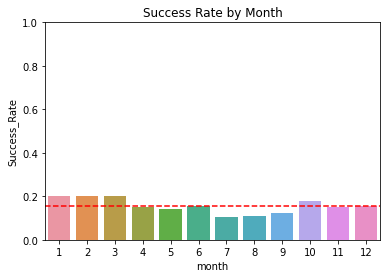

In [16]:
#look at relationshp between month and success

#group the data by month
df_success_month = df.groupby('month').agg({'Success':'sum', 'Model_B':'count'}) \
    .reset_index() \
    .rename(columns={'Model_B':'Count'})

#calculate success rates
df_success_month['Success_Rate'] = df_success_month.Success / df_success_month.Count


#inspect the different success rates
sns.barplot(x='month', y='Success_Rate', data=df_success_month);
plt.gca().set(ylim=(0,1));
plt.gca().set_title('Success Rate by Month')

#plot the overall success rate
plt.gca().axhline(success_rate, linestyle='--', color='red');

Success rates are highest in the 1st quarter of the year. They tend to be lowest in the 3rd quarter and moderate in quarters 2 and 4. A feature can be created to reflect the quarter.

In [17]:
#function to map month to quarter
def map_month_quarter(row):
    if row['month'] <= 3:
        return 'Q1'
    elif row['month'] >3 and row['month'] <=6:
        return 'Q2'
    elif row['month'] >6 and row['month'] <=9:
        return 'Q3'
    else:
        return 'Q4'

In [18]:
#map each month to a quarter
df['quarter'] = df.apply(lambda row : map_month_quarter(row), axis=1)

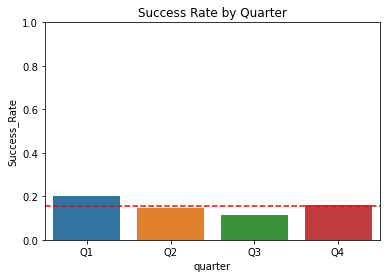

In [19]:
#look at relationshp between quarter and success

#group the data by quarter
df_success_quarter = df.groupby('quarter').agg({'Success':'sum', 'Model_B':'count'}) \
    .reset_index() \
    .rename(columns={'Model_B':'Count'})

#calculate success rates
df_success_quarter['Success_Rate'] = df_success_quarter.Success / df_success_quarter.Count


#inspect the different success rates
sns.barplot(x='quarter', y='Success_Rate', data=df_success_quarter);
plt.gca().set(ylim=(0,1));
plt.gca().set_title('Success Rate by Quarter')

#plot the overall success rate
plt.gca().axhline(success_rate, linestyle='--', color='red');

## Drop Unneeded Columns

In [22]:
#drop the Date column
df.drop(columns=['Date'],inplace=True)

## Part 2

## Preprocessing

In [23]:
#set a value from random state to ensure repeatability
random_state=42

In [24]:
#separate X (feature matrix) and y (target vector)
X = df.drop(columns=['Success'])
y = df.Success

In [25]:
#train/test split
X_train, X_test, y_train, y_test = \
    model_selection.train_test_split(X, y, train_size=0.7, stratify=y, random_state=random_state)

**Categorical Encoding**

In [26]:
#encode categorical columns using One Hot Encoding

#get the categorical columns from the training data
categorical_columns = ['month', 'quarter']
df_categorical = X_train[categorical_columns]

#initialize the One Hot encoder
encoder = preprocessing.OneHotEncoder(sparse=False)

#fit the encoder to the training data, encode the training data, add the encoded columns to the dataframe
encoded_cols = encoder.fit_transform(df_categorical)
df_encoded = pd.DataFrame(encoded_cols, 
                          columns=encoder.get_feature_names(categorical_columns),
                         index=X_train.index)
X_train = pd.concat([X_train,df_encoded], axis=1)

#drop the original categorical columns
X_train.drop(columns=categorical_columns, inplace=True)


#get the categorical columns from the test data
df_categorical = X_test[categorical_columns]

#encode the test data using the encoder that was fitted to the training data
encoded_cols = encoder.transform(df_categorical)
df_encoded = pd.DataFrame(encoded_cols, 
                          columns=encoder.get_feature_names(categorical_columns),
                         index=X_test.index)
X_test = pd.concat([X_test,df_encoded], axis=1)

#drop the original categorical columns
X_test.drop(columns=categorical_columns, inplace=True)

**Typically the numerical columns would be scaled. However, this data already appears to have been scaled so the scaling step can be skipped**

## Multicollinearity

**Remove the Feature With the Greatest VIF Until All Features Have VIF < 2:**

In [27]:
#We want to keep the Model_B feature. Therefore, we will remove it from the dataframe, remove multicollinear features,
#and then add Model_B back to the dataframe.
X_train_model_B = X_train['Model_B']
X_test_model_B = X_test['Model_B']

X_train.drop(columns=['Model_B'], inplace=True)
X_test.drop(columns=['Model_B'], inplace=True)

In [28]:
#remove features until VIF among all features is < 2

X_train = X_train.sort_index(axis=1)
X_test = X_test.sort_index(axis=1)

while len(X_train.columns) > 0:

    df_VIF = pd.DataFrame({'Feature':X_train.columns})
    df_VIF['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(len(X_train.columns))]
    
    if df_VIF.loc[df_VIF['VIF'].idxmax()]['VIF'] < 2:
        break
        
    X_train = X_train.drop(columns=df_VIF.loc[df_VIF['VIF'].idxmax()]['Feature'])    

divide by zero encountered in double_scalars


**Select the same columns from the test data**

In [29]:
#Select the same columns from the test data
X_test = X_test[X_train.columns]

**Add the Model_B columns back into the dataset**

In [30]:
#add the model B columns back to X_train and X_test
X_train['Model_B'] = X_train_model_B 
X_test['Model_B'] = X_test_model_B 

In [31]:
X_train.head()

,X2,X3,month_11,month_12,month_2,month_3,month_5,month_6,month_8,month_9,Model_B
2062,-0.935495,-1.656392,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.765860
1966,0.754162,0.162420,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.320886
4758,1.681657,2.247262,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.219703
1949,-0.006841,-0.064094,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.770482
1891,0.188642,0.828965,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.347914


After removing multicollinear columns, only X2 and X3 remain from the new features. This is not surprising because we noted above that X3 and X4 were highly correlated. We also noted that X1 had a moderately high correlation with X3 and X4.

## Modeling

## Evaluation Metric Selection

In [11]:
success_count = df[df['Success'] == 1].shape[0]
failure_count = df[df['Success'] == 0].shape[0]

success_value = success_count * 0.24 #Net margin determined by 0.25-0.01
failure_cost = failure_count * 0.01

print('Value generated by all successes ${}'.format(round(success_value,2)))
print('Cost of all failures ${}'.format(round(failure_cost,2)))

Value generated by all successes $224.16
Cost of all failures $50.66


If we make the assumption that the ratio of successes to failures in future email campaigns is similar to the ratio in this dataset, then we can see (above cell) that the value generated by the successes greatly exceeds the cost of the failures. Therefore, we want to ensure that we identify as many of the potential successes as we possibly can. For this reason we can use **recall** to evaluate our models. 

## 1. Models trained using the full dataset

In [33]:
#method to train, predict, and score each model
def train_predict_score(model, X_train, y_train, X_test, y_test):
    model.fit(X_train,y_train)
    
    #metrics on training data
    train_accuracy = metrics.accuracy_score(y_train,model.predict(X_train))
    train_auc = metrics.roc_auc_score(y_train,model.predict_proba(X_train)[:,1])
    train_f1 = metrics.f1_score(y_train,model.predict(X_train))
    train_recall = metrics.recall_score(y_train, model.predict(X_train))
    train_precision = metrics.precision_score(y_train, model.predict(X_train))
    
    #metrics on test data
    test_accuracy = metrics.accuracy_score(y_test,model.predict(X_test))
    test_auc = metrics.roc_auc_score(y_test,model.predict_proba(X_test)[:,1])
    test_f1 = metrics.f1_score(y_test,model.predict(X_test))
    test_recall = metrics.recall_score(y_test, model.predict(X_test))
    test_precision = metrics.precision_score(y_test, model.predict(X_test))
      
    return dict({
        'Train Accuracy':train_accuracy,
        'Train AUC': train_auc,
        'Train F1': train_f1,
        'Train Recall': train_recall,
        'Train Precision': train_precision,
        'Test Accuracy':test_accuracy,
        'Test AUC':test_auc,
        'Test F1':test_f1,
        'Test Recall': test_recall,
        'Test Precision': test_precision})

In [34]:
#DataFrame to hold scores
model_scores = pd.DataFrame(columns=['Model','Train Accuracy','Train AUC','Train F1', 'Train Recall', 
                                     'Train Precision', 'Test Accuracy','Test AUC', 'Test F1',
                                     'Test Recall', 'Test Precision'])

In [35]:
#baseline model
dummy_model = dummy.DummyClassifier(random_state = random_state, strategy='uniform')

dict_score = train_predict_score(dummy_model, X_train, y_train, X_test, y_test)
dict_score['Model'] = 'Dummy'

model_scores = model_scores.append(dict_score, ignore_index=True)

In [36]:
#initial logistic regression model
lr_model = linear_model.LogisticRegression(random_state=random_state)

dict_score = train_predict_score(lr_model, X_train, y_train, X_test, y_test)
dict_score['Model'] = 'Logistic Regression'

model_scores = model_scores.append(dict_score, ignore_index=True)

In [37]:
#initial gradient boosting model
gb_model = ensemble.GradientBoostingClassifier(random_state=random_state)

dict_score = train_predict_score(gb_model, X_train, y_train, X_test, y_test)
dict_score['Model'] = 'Gradient Boosting'

model_scores = model_scores.append(dict_score, ignore_index=True)

In [38]:
#initial random forest model
rf_model = ensemble.RandomForestClassifier(random_state=random_state)

dict_score = train_predict_score(rf_model, X_train, y_train, X_test, y_test)
dict_score['Model'] = 'Random Forest'

model_scores = model_scores.append(dict_score, ignore_index=True)

In [39]:
#initial XG Boost model

xgb_model = XGBClassifier(use_label_encoder=False, seed=random_state)

dict_score = train_predict_score(xgb_model, X_train, y_train, X_test, y_test)
dict_score['Model'] = 'XG Boost'

model_scores = model_scores.append(dict_score, ignore_index=True)

[16:35:20] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [40]:
#inspect the initial model scores
display(model_scores.sort_values(by='Test Recall', ascending=False))

,Model,Train Accuracy,Train AUC,Train F1,Train Recall,Train Precision,Test Accuracy,Test AUC,Test F1,Test Recall,Test Precision
3,Random Forest,1.000000,1.000000,1.000000,1.000000,1.000000,0.948889,0.974854,0.836299,0.839286,0.833333
2,Gradient Boosting,0.960476,0.990844,0.869085,0.842508,0.897394,0.949444,0.980678,0.833028,0.810714,0.856604
4,XG Boost,0.998810,0.999997,0.996169,0.993884,0.998464,0.941667,0.979142,0.811490,0.807143,0.815884
1,Logistic Regression,0.936429,0.976972,0.780968,0.727829,0.842478,0.944444,0.980458,0.814126,0.782143,0.848837
0,Dummy,0.496667,0.500000,0.235719,0.498471,0.154356,0.505000,0.500000,0.237810,0.496429,0.156355


After initial testing, the Random Forest model was the best model. It had the top Recall score and therefore should identify as many Successes as possible. 

Additionally, the Random Forest model had the best F1 score which indicates that it should be a good predictor of Successful email campaigns. This is important because although we want to use recall as our evaluation metric, we also want to ensure that we are not "over-predicting" Success which would result in a model that does not provide any value.      

## Hyperparameter Tuning

In [41]:
#define the hyperparameter search grid
grid_params = {
    'n_estimators':[50, 100, 200, 500, 1000],
    'max_depth':[3,6,7,8,9,10, None],
    'max_features': ['sqrt','log2','None']
}

#Random Forest model (best score in initial modeling)
rf_model_2 = ensemble.RandomForestClassifier(random_state=random_state)

#Randomized CV search for best hyperparameters
tuned_rf_model = model_selection.RandomizedSearchCV(rf_model_2,grid_params, scoring='recall',n_jobs=-1, 
                                                    cv=15, random_state=random_state, n_iter=30)

#train the model, make predictions on train and test sets, evaluation metrics
dict_so = train_predict_score(tuned_rf_model, X_train, y_train, X_test, y_test)
dict_score['Model'] = 'Tuned Random Forest'

model_scores = model_scores.append(dict_score, ignore_index=True)

One or more of the test scores are non-finite: [0.79041579 0.77505285 0.78735025 0.78576462 0.78118393 0.77963354
        nan 0.78421424        nan 0.7521494  0.78731501 0.79041579
        nan 0.78118393 0.78121917 0.74453841 0.78273432 0.78121917
        nan        nan 0.77963354        nan 0.78424947 0.78424947
        nan        nan 0.78731501        nan        nan 0.74453841]


In [42]:
#check the best parameters
tuned_rf_model.best_params_

{'n_estimators': 100, 'max_features': 'sqrt', 'max_depth': 7}

In [43]:
#inspect all model scores
display(model_scores.sort_values(by='Test Recall', ascending=False))

,Model,Train Accuracy,Train AUC,Train F1,Train Recall,Train Precision,Test Accuracy,Test AUC,Test F1,Test Recall,Test Precision
3,Random Forest,1.000000,1.000000,1.000000,1.000000,1.000000,0.948889,0.974854,0.836299,0.839286,0.833333
2,Gradient Boosting,0.960476,0.990844,0.869085,0.842508,0.897394,0.949444,0.980678,0.833028,0.810714,0.856604
4,XG Boost,0.998810,0.999997,0.996169,0.993884,0.998464,0.941667,0.979142,0.811490,0.807143,0.815884
5,Tuned Random Forest,0.998810,0.999997,0.996169,0.993884,0.998464,0.941667,0.979142,0.811490,0.807143,0.815884
1,Logistic Regression,0.936429,0.976972,0.780968,0.727829,0.842478,0.944444,0.980458,0.814126,0.782143,0.848837
0,Dummy,0.496667,0.500000,0.235719,0.498471,0.154356,0.505000,0.500000,0.237810,0.496429,0.156355


**We were unable to improve on the best model using hyperparameter tuning. The original Random Forest model had better Recall, Precision, and F1 scores. Therefore, the original Random Forest model is one of the models we will consider for our final model**

## 2. Models trained using Segmented datasets based on X1

During EDA we saw that X1 may be an important predictor of Success/Failure. Therefore, we can try segmenting the data based on X1 as a preprocessing step. This may improve the ability of our models to predict successful email campaigns.

In [44]:
#get train/test data when X1 = True
X_train_X1_true = X_train[df['X1'] == 1]
y_train_X1_true = y_train[X_train_X1_true.index]
X_test_X1_true = X_test[df['X1'] == 1]
y_test_X1_true = y_test[X_test_X1_true.index]

#get train/test data when X1 = False
X_train_X1_false = X_train[df['X1'] == 0]
y_train_X1_false = y_train[X_train_X1_false.index]
X_test_X1_false = X_test[df['X1'] == 0]
y_test_X1_false = y_test[X_test_X1_false.index]

Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.


## 2.1 Train Models on Data where X1 is True

In [45]:
#initial logistic regression model
lr_model_X1_True = linear_model.LogisticRegression(random_state=random_state)

dict_score = train_predict_score(lr_model_X1_True, X_train_X1_true, y_train_X1_true, 
                                 X_test_X1_true, y_test_X1_true)
dict_score['Model'] = 'Logistic Regression, X1 = True'

model_scores = model_scores.append(dict_score, ignore_index=True)

In [46]:
#initial gradient boosting model
gb_model_X1_True = ensemble.GradientBoostingClassifier(random_state=random_state)

dict_score = train_predict_score(gb_model_X1_True, X_train_X1_true, y_train_X1_true, 
                                 X_test_X1_true, y_test_X1_true)
dict_score['Model'] = 'Gradient Boosting, X1 = True'

model_scores = model_scores.append(dict_score, ignore_index=True)

In [47]:
#initial random forest model
rf_model_X1_True = ensemble.RandomForestClassifier(random_state=random_state)

dict_score = train_predict_score(rf_model_X1_True, X_train_X1_true, y_train_X1_true, 
                                 X_test_X1_true, y_test_X1_true)
dict_score['Model'] = 'Random Forest, X1 = True'

model_scores = model_scores.append(dict_score, ignore_index=True)

In [48]:
#initial XG Boost model

xgb_model_X1_True = XGBClassifier(use_label_encoder=False, seed=random_state)

dict_score = train_predict_score(xgb_model_X1_True, X_train_X1_true, y_train_X1_true, 
                                 X_test_X1_true, y_test_X1_true)
dict_score['Model'] = 'XG Boost, X1 = True'

model_scores = model_scores.append(dict_score, ignore_index=True)

[16:36:11] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [49]:
#inspect the model scores
display(model_scores.sort_values(by='Test Recall', ascending=False))

,Model,Train Accuracy,Train AUC,Train F1,Train Recall,Train Precision,Test Accuracy,Test AUC,Test F1,Test Recall,Test Precision
8,"Random Forest, X1 = True",1.000000,1.000000,1.000000,1.000000,1.000000,0.914819,0.962655,0.854871,0.877551,0.833333
9,"XG Boost, X1 = True",1.000000,1.000000,1.000000,1.000000,1.000000,0.904317,0.963999,0.837945,0.865306,0.812261
7,"Gradient Boosting, X1 = True",0.943414,0.986442,0.895548,0.876047,0.915937,0.913652,0.967237,0.848980,0.848980,0.848980
3,Random Forest,1.000000,1.000000,1.000000,1.000000,1.000000,0.948889,0.974854,0.836299,0.839286,0.833333
6,"Logistic Regression, X1 = True",0.899814,0.962138,0.808171,0.762144,0.860113,0.905484,0.965853,0.834356,0.832653,0.836066
2,Gradient Boosting,0.960476,0.990844,0.869085,0.842508,0.897394,0.949444,0.980678,0.833028,0.810714,0.856604
4,XG Boost,0.998810,0.999997,0.996169,0.993884,0.998464,0.941667,0.979142,0.811490,0.807143,0.815884
5,Tuned Random Forest,0.998810,0.999997,0.996169,0.993884,0.998464,0.941667,0.979142,0.811490,0.807143,0.815884
1,Logistic Regression,0.936429,0.976972,0.780968,0.727829,0.842478,0.944444,0.980458,0.814126,0.782143,0.848837
0,Dummy,0.496667,0.500000,0.235719,0.498471,0.154356,0.505000,0.500000,0.237810,0.496429,0.156355


For the X1 = True segment, the Random Forest model is once again the best model. It is the best performer in terms of Recall which is desirable for predicting as many Successes as possible. It is also the best performer in terms of F1-Score which helps to indicate that the model is balanced and has good predictive power.

## Hyperparameter Tuning

In [50]:
#for the model where X1 = true

#define the hyperparameter search grid
grid_params = {
    'n_estimators':[50, 100, 200, 500, 1000],
    'max_depth':[3,6,7,8,9,10, None],
    'max_features': ['sqrt','log2','None']
}

#Random Forest model (best score in initial modeling)
rf_model_2_X1_True = ensemble.RandomForestClassifier(random_state=random_state)

#Randomized CV search for best hyperparameters
tuned_rf_model_X1_True = model_selection.RandomizedSearchCV(rf_model_2_X1_True,grid_params, scoring='recall',n_jobs=-1, 
                                                    cv=15, random_state=random_state, n_iter=30)

#train the model, make predictions on train and test sets, evaluation metrics
dict_so = train_predict_score(tuned_rf_model_X1_True, X_train_X1_true, y_train_X1_true, 
                                 X_test_X1_true, y_test_X1_true)
dict_score['Model'] = 'Tuned Random Forest, X1 = True'

model_scores = model_scores.append(dict_score, ignore_index=True)

One or more of the test scores are non-finite: [0.79730769 0.8007265  0.80235043 0.80568376 0.80568376 0.80235043
        nan 0.80905983        nan 0.79059829 0.80401709 0.79564103
        nan 0.80410256 0.80910256 0.78897436 0.80410256 0.80230769
        nan        nan 0.80235043        nan 0.80235043 0.81076923
        nan        nan 0.79730769        nan        nan 0.78897436]


In [51]:
#inspect the model scores
display(model_scores.sort_values(by='Test Recall', ascending=False))

,Model,Train Accuracy,Train AUC,Train F1,Train Recall,Train Precision,Test Accuracy,Test AUC,Test F1,Test Recall,Test Precision
8,"Random Forest, X1 = True",1.000000,1.000000,1.000000,1.000000,1.000000,0.914819,0.962655,0.854871,0.877551,0.833333
9,"XG Boost, X1 = True",1.000000,1.000000,1.000000,1.000000,1.000000,0.904317,0.963999,0.837945,0.865306,0.812261
10,"Tuned Random Forest, X1 = True",1.000000,1.000000,1.000000,1.000000,1.000000,0.904317,0.963999,0.837945,0.865306,0.812261
7,"Gradient Boosting, X1 = True",0.943414,0.986442,0.895548,0.876047,0.915937,0.913652,0.967237,0.848980,0.848980,0.848980
3,Random Forest,1.000000,1.000000,1.000000,1.000000,1.000000,0.948889,0.974854,0.836299,0.839286,0.833333
6,"Logistic Regression, X1 = True",0.899814,0.962138,0.808171,0.762144,0.860113,0.905484,0.965853,0.834356,0.832653,0.836066
2,Gradient Boosting,0.960476,0.990844,0.869085,0.842508,0.897394,0.949444,0.980678,0.833028,0.810714,0.856604
4,XG Boost,0.998810,0.999997,0.996169,0.993884,0.998464,0.941667,0.979142,0.811490,0.807143,0.815884
5,Tuned Random Forest,0.998810,0.999997,0.996169,0.993884,0.998464,0.941667,0.979142,0.811490,0.807143,0.815884
1,Logistic Regression,0.936429,0.976972,0.780968,0.727829,0.842478,0.944444,0.980458,0.814126,0.782143,0.848837


Once again, we were unable to improve upon the best model with hyperparameter tuning

## 2.2 Train Models on Data where X1 is False

In [52]:
#initial logistic regression model
lr_model_X1_False = linear_model.LogisticRegression(random_state=random_state)

dict_score = train_predict_score(lr_model_X1_False, X_train_X1_false, y_train_X1_false, 
                                 X_test_X1_false, y_test_X1_false)
dict_score['Model'] = 'Logistic Regression, X1 = False'

model_scores = model_scores.append(dict_score, ignore_index=True)

In [53]:
#initial gradient boosting model
gb_model_X1_False = ensemble.GradientBoostingClassifier(random_state=random_state)

dict_score = train_predict_score(gb_model_X1_False, X_train_X1_false, y_train_X1_false, 
                                 X_test_X1_false, y_test_X1_false)
dict_score['Model'] = 'Gradient Boosting, X1 = False'

model_scores = model_scores.append(dict_score, ignore_index=True)

In [54]:
#initial random forest model
rf_model_X1_False = ensemble.RandomForestClassifier(random_state=random_state)

dict_score = train_predict_score(rf_model_X1_False, X_train_X1_false, y_train_X1_false, 
                                 X_test_X1_false, y_test_X1_false)
dict_score['Model'] = 'Random Forest, X1 = False'

model_scores = model_scores.append(dict_score, ignore_index=True)

In [55]:
#initial XG Boost model
xgb_model_X1_False = XGBClassifier(use_label_encoder=False, seed=random_state)

dict_score = train_predict_score(xgb_model_X1_False, X_train_X1_false, y_train_X1_false, 
                                 X_test_X1_false, y_test_X1_false)
dict_score['Model'] = 'XG Boost, X1 = False'

model_scores = model_scores.append(dict_score, ignore_index=True)

[16:36:49] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [56]:
#inspect the model scores
display(model_scores.sort_values(by='Test Recall', ascending=False))

,Model,Train Accuracy,Train AUC,Train F1,Train Recall,Train Precision,Test Accuracy,Test AUC,Test F1,Test Recall,Test Precision
8,"Random Forest, X1 = True",1.000000,1.000000,1.000000,1.000000,1.000000,0.914819,0.962655,0.854871,0.877551,0.833333
9,"XG Boost, X1 = True",1.000000,1.000000,1.000000,1.000000,1.000000,0.904317,0.963999,0.837945,0.865306,0.812261
10,"Tuned Random Forest, X1 = True",1.000000,1.000000,1.000000,1.000000,1.000000,0.904317,0.963999,0.837945,0.865306,0.812261
7,"Gradient Boosting, X1 = True",0.943414,0.986442,0.895548,0.876047,0.915937,0.913652,0.967237,0.848980,0.848980,0.848980
3,Random Forest,1.000000,1.000000,1.000000,1.000000,1.000000,0.948889,0.974854,0.836299,0.839286,0.833333
6,"Logistic Regression, X1 = True",0.899814,0.962138,0.808171,0.762144,0.860113,0.905484,0.965853,0.834356,0.832653,0.836066
2,Gradient Boosting,0.960476,0.990844,0.869085,0.842508,0.897394,0.949444,0.980678,0.833028,0.810714,0.856604
4,XG Boost,0.998810,0.999997,0.996169,0.993884,0.998464,0.941667,0.979142,0.811490,0.807143,0.815884
5,Tuned Random Forest,0.998810,0.999997,0.996169,0.993884,0.998464,0.941667,0.979142,0.811490,0.807143,0.815884
1,Logistic Regression,0.936429,0.976972,0.780968,0.727829,0.842478,0.944444,0.980458,0.814126,0.782143,0.848837


## Hyperparameter Tuning

In [57]:
#for the model where X1 = false

#define the hyperparameter search grid
grid_params = {
    'n_estimators':[50, 100, 200, 500, 1000],
    'max_depth':[3,6,7,8,9,10, None],
    'max_features': ['sqrt','log2','None']
}

#Random Forest model (best score in initial modeling)
rf_model_2_X1_False = ensemble.RandomForestClassifier(random_state=random_state)

#Randomized CV search for best hyperparameters
tuned_rf_model_X1_False = model_selection.RandomizedSearchCV(rf_model_2_X1_False,grid_params, scoring='recall',n_jobs=-1, 
                                                    cv=15, random_state=random_state, n_iter=30)

#train the model, make predictions on train and test sets, evaluation metrics
dict_so = train_predict_score(tuned_rf_model_X1_True, X_train_X1_false, y_train_X1_false, 
                                 X_test_X1_false, y_test_X1_false)
dict_score['Model'] = 'Tuned Random Forest, X1 = False'

model_scores = model_scores.append(dict_score, ignore_index=True)

One or more of the test scores are non-finite: [0.46111111 0.47777778 0.51111111 0.46111111 0.47777778 0.51666667
        nan 0.5               nan 0.35       0.47777778 0.49444444
        nan 0.47777778 0.51666667 0.33333333 0.49444444 0.47777778
        nan        nan 0.51666667        nan 0.47777778 0.51666667
        nan        nan 0.46111111        nan        nan 0.33333333]


In [58]:
#inspect the model scores
display(model_scores.sort_values(by='Test Recall', ascending=False))

,Model,Train Accuracy,Train AUC,Train F1,Train Recall,Train Precision,Test Accuracy,Test AUC,Test F1,Test Recall,Test Precision
8,"Random Forest, X1 = True",1.000000,1.000000,1.000000,1.000000,1.000000,0.914819,0.962655,0.854871,0.877551,0.833333
9,"XG Boost, X1 = True",1.000000,1.000000,1.000000,1.000000,1.000000,0.904317,0.963999,0.837945,0.865306,0.812261
10,"Tuned Random Forest, X1 = True",1.000000,1.000000,1.000000,1.000000,1.000000,0.904317,0.963999,0.837945,0.865306,0.812261
7,"Gradient Boosting, X1 = True",0.943414,0.986442,0.895548,0.876047,0.915937,0.913652,0.967237,0.848980,0.848980,0.848980
3,Random Forest,1.000000,1.000000,1.000000,1.000000,1.000000,0.948889,0.974854,0.836299,0.839286,0.833333
6,"Logistic Regression, X1 = True",0.899814,0.962138,0.808171,0.762144,0.860113,0.905484,0.965853,0.834356,0.832653,0.836066
2,Gradient Boosting,0.960476,0.990844,0.869085,0.842508,0.897394,0.949444,0.980678,0.833028,0.810714,0.856604
4,XG Boost,0.998810,0.999997,0.996169,0.993884,0.998464,0.941667,0.979142,0.811490,0.807143,0.815884
5,Tuned Random Forest,0.998810,0.999997,0.996169,0.993884,0.998464,0.941667,0.979142,0.811490,0.807143,0.815884
1,Logistic Regression,0.936429,0.976972,0.780968,0.727829,0.842478,0.944444,0.980458,0.814126,0.782143,0.848837


Like the other cases, hyperparameter tuning for the X1 = False segment was unable to improve the model's performance.

## Model Selection

In [59]:
#look at the best model for each segment
model_scores.iloc[[8, 3, 13]].sort_values(by='Test Recall', ascending=False)

,Model,Train Accuracy,Train AUC,Train F1,Train Recall,Train Precision,Test Accuracy,Test AUC,Test F1,Test Recall,Test Precision
8,"Random Forest, X1 = True",1.0,1.0,1.0,1.0,1.0,0.914819,0.962655,0.854871,0.877551,0.833333
3,Random Forest,1.0,1.0,1.0,1.0,1.0,0.948889,0.974854,0.836299,0.839286,0.833333
13,"Random Forest, X1 = False",1.0,1.0,1.0,1.0,1.0,0.983033,0.983638,0.724138,0.600000,0.913043


We can see that the model built using the X1 = True segment had the highest recall and F1 score. However, the model trained on the X1 = False segment had poor recall and F1 Scores compared to the model trained on all data. That said, we should keep in mind that the X1 = False data did not contain many Successes. 

In order to select the best model we need to look at which of the following models had the most successes:
* Random Forest
* Random Forest, X1 = True + Random Forest, X1 = False



In [19]:
#get each model's predictions , we will use cutoff of 0.1556 as the proportion of success in X_train dataset is 15.56%,similarly for segmented dataset we will use 0.2769 and 0.027 respectively
rf_predictions = (rf_model.predict_proba(X_test)[:,1] > 0.1556).astype(np.int64)
rf_x1_true_predictions = (rf_model_X1_True.predict_proba(X_test_X1_true)[:,1] > 0.2769).astype(np.int64)
rf_x1_false_predictions = (rf_model_X1_False.predict_proba(X_test_X1_false)[:,1] > 0.027).astype(np.int64)

In [20]:
#look at number of successes in order to select Model A
rf_successes = ((rf_predictions == y_test) & (y_test == 1)).sum()
rf_x1_true_successes = ((rf_x1_true_predictions == y_test_X1_true) & (y_test_X1_true == 1)).sum()
rf_x1_false_successes = ((rf_x1_false_predictions == y_test_X1_false) & (y_test_X1_false == 1)).sum()

rf_segmented_successes = rf_x1_true_successes + rf_x1_false_successes

print('Correctly predicted successes, all data:', rf_successes)
print('Correctly predicted successes, X1 segmented data:', rf_segmented_successes)

Correctly predicted successes, all data: 261
Correctly predicted successes, X1 segmented data: 264


With segmented data, there was one more correctly predicted success compared to the model that was trained on the full dataset. Because the models had very similar performances in terms of predicting Successes, it may be worth doing a cost/benefit analysis by taking false positives into account.

In [21]:
#account for false positives
rf_fp = ((rf_predictions != y_test) & (rf_predictions == 1)).sum()
rf_x1_true_fp = ((rf_x1_true_predictions != y_test_X1_true) & (rf_x1_true_predictions == 1)).sum()
rf_x1_false_fp = ((rf_x1_false_predictions != y_test_X1_false) & (rf_x1_false_predictions == 1)).sum()

rf_segmented_fp = rf_x1_true_fp + rf_x1_false_fp

print('False positives, all data:', rf_fp)
print('False positives, X1 segmented data:', rf_segmented_fp)

False positives, all data: 129
False positives, X1 segmented data: 150


In [23]:
#examine the net value produced by each modeling approach
print('Value generated, all data: ${}'.format((rf_successes * 0.24) - (rf_fp * 0.01)))
print('Value generated, segmented data: ${}'.format((rf_segmented_successes * 0.24) - (rf_segmented_fp * 0.01)))

Value generated, all data: $61.35
Value generated, segmented data: $61.86


When segmenting the data using X1, we correctly predict more successful email campaigns and also generate more value. Therefore, the segmented approach appears to be the best approach.

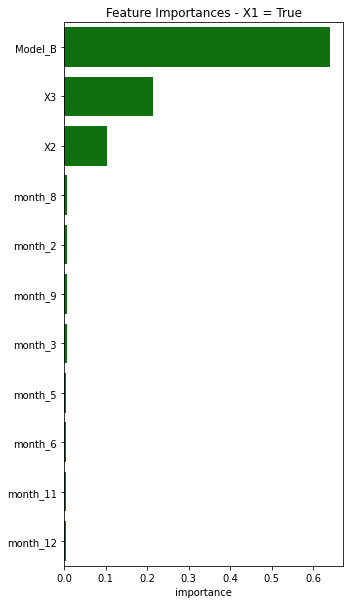

In [64]:
#examine feature importances, X1 = True segment

df_feature_importances = \
    pd.DataFrame(rf_model_X1_True.feature_importances_, index=X_train_X1_true.columns, columns=['importance']) \
        .sort_values(by='importance', ascending=False)


plt.subplots(figsize=(5,10))
sns.barplot(data=df_feature_importances, y=df_feature_importances.index, x='importance', color='green', orient='h');
plt.gca().set_title('Feature Importances - X1 = True');

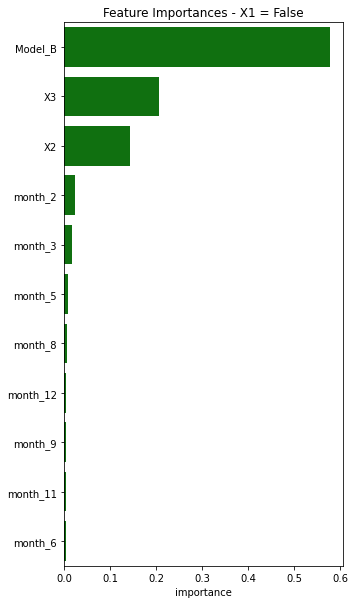

In [65]:
#examine feature importances, X1 = False Segment

df_feature_importances = \
    pd.DataFrame(rf_model_X1_False.feature_importances_, index=X_train_X1_false.columns, columns=['importance']) \
        .sort_values(by='importance', ascending=False)


plt.subplots(figsize=(5,10))
sns.barplot(data=df_feature_importances, y=df_feature_importances.index, x='importance', color='green', orient='h');
plt.gca().set_title('Feature Importances - X1 = False');

**Model A significantly relies on the output of Model B - this is by far the most important feature. However, X3 also had a fairly large contribution to the model. X2 and the month of August (month_8) also showed some importance. After, the top 4 features there was significant drop off in importance. It may be worth trying to build a model with only the top 4 features. This could lead to a simple, more robust, model.**

**SHAP Analysis**

In [66]:
#get SHAP values for the X1 = True segment

X_test_sample = shap.sample(X_test_X1_true,300)
explainer = shap.KernelExplainer(rf_model_X1_True.predict, X_test_sample)
shap_values = explainer.shap_values(X_test_sample)

Using 300 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/300 [00:00<?, ?it/s]

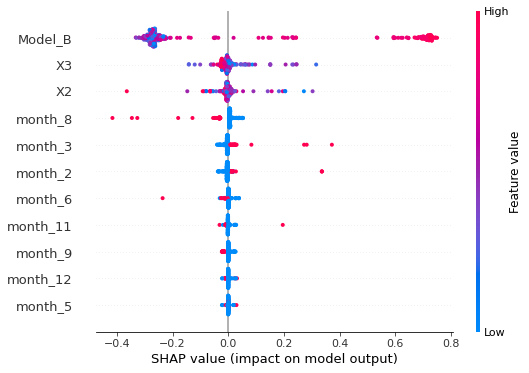

In [67]:
#create SHAP summary plot

shap.summary_plot(shap_values, X_test_sample)

In [68]:
#get SHAP values for the X1 = False segment

X_test_sample = shap.sample(X_test_X1_false,300)
explainer = shap.KernelExplainer(rf_model_X1_False.predict, X_test_sample)
shap_values = explainer.shap_values(X_test_sample)

Using 300 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/300 [00:00<?, ?it/s]

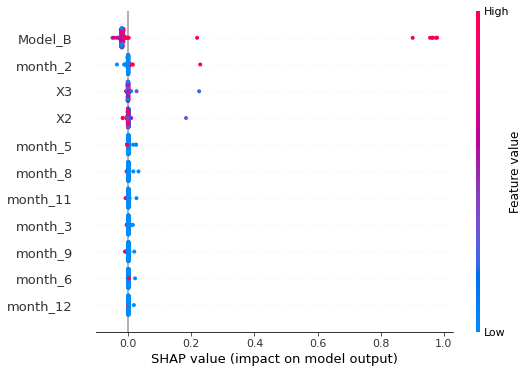

In [69]:
#create SHAP summary plot

shap.summary_plot(shap_values, X_test_sample)

**As the Model_B value increases, it impacts the probability of success in a positive way whereas for X2 and X3 as the value increases the probability of success decreases**

## Part 3

In [70]:
#get the model B predictions
Model_B_predictions = (X_test.Model_B > 0.5).astype(np.int64)

#get the number of true positives for Model A vs. Model B
model_A_tp = rf_segmented_successes
model_B_tp = ((Model_B_predictions == y_test) & (y_test == 1)).sum()

#calculate recall for model B
model_B_fn = ((Model_B_predictions != y_test) & (Model_B_predictions == 0)).sum()
model_B_recall = model_B_tp / (model_B_tp + model_B_fn)

#calculate recall for model A
rf_x1_true_fn = ((rf_x1_true_predictions != y_test_X1_true) & (rf_x1_true_predictions == 0)).sum()
rf_x1_false_fn = ((rf_x1_false_predictions != y_test_X1_false) & (rf_x1_false_predictions == 0)).sum()
model_A_fn = rf_x1_true_fn + rf_x1_false_fn

model_A_recall = rf_successes / (rf_successes + model_A_fn)

#DataFrame to hold correct prediction count
df_model_comparison = pd.DataFrame(columns=['Model','True Positives','Recall'])
df_model_comparison = \
    df_model_comparison.append(dict({'Model':'A', 'True Positives': model_A_tp, 
                                 'Recall':model_A_recall}), ignore_index=True)
df_model_comparison = \
    df_model_comparison.append(dict({'Model':'B', 'True Positives': model_B_tp, 
                                 'Recall':model_B_recall}), ignore_index=True)

In [30]:
df_model_comparison

,Model,True Positives,Recall
0,A,264,0.942238
1,B,280,1.0


**Model B outperformed Model A in terms of both True Positives and Recall**

## Part 4

In [73]:
#Model A (segment X1 = True) predctions and actuals
df_x1_true_predictions = pd.DataFrame(rf_model_X1_True.predict_proba(X_test_X1_true)[:,1])
df_x1_true_predictions.index = y_test_X1_true.index
df_x1_true_predictions['Actual'] = y_test_X1_true

#rename the predictions column
df_x1_true_predictions.rename(columns={0:'Model_A_Prob'}, inplace=True)

#Model A (segment X1 = False) predictions and actuals
df_x1_false_predictions = pd.DataFrame(rf_model_X1_False.predict_proba(X_test_X1_false)[:,1])
df_x1_false_predictions.index = y_test_X1_false.index
df_x1_false_predictions['Actual'] = y_test_X1_false

#rename the predictions column
df_x1_false_predictions.rename(columns={0:'Model_A_Prob'}, inplace=True)

#stack the dataframes into a single set of of predictions/actuals for Model A
df_actual_pred = pd.concat([df_x1_true_predictions, df_x1_false_predictions])

#add the model B predictions
df_actual_pred = pd.concat([df_actual_pred, X_test.Model_B], axis=1)
df_actual_pred = df_actual_pred.rename(columns={'Model_B':'Model_B_Prob'})

## Model A

In [74]:
#since Model A predicted a lot of 0s we cannot use qcut on the 'Model_A_Prob' column,
#therefore we can sort the dataframe and use rank values
df_actual_pred = df_actual_pred.sort_values(by='Model_A_Prob')
df_actual_pred['Rank_A'] = range(1,len(df_actual_pred) + 1)

#cut the dataframe into 10 equal sized buckets (based on Model A Predictions)
df_actual_pred['Bin'] = pd.qcut(df_actual_pred['Rank_A'],10)

#group the data in order to inspect profit/loss for each bin/group
df_grouped_data_A = df_actual_pred.groupby('Bin').agg({'Actual':'sum', 'Model_A_Prob':'count'}) \
    .rename(columns={'Model_A_Prob':'Count', 'Actual':'Successes'})

#determine the cost of the emails and the value provided by the emails for each group/bin
df_grouped_data_A['Cost'] = df_grouped_data_A['Count'] * 0.01
df_grouped_data_A['Value'] = df_grouped_data_A['Successes'] * 0.25

#determine profit or loss for each group/bin
df_grouped_data_A['P/L'] = df_grouped_data_A['Value'] - df_grouped_data_A['Cost']

df_actual_pred.drop(columns=['Rank_A','Bin'], inplace=True)

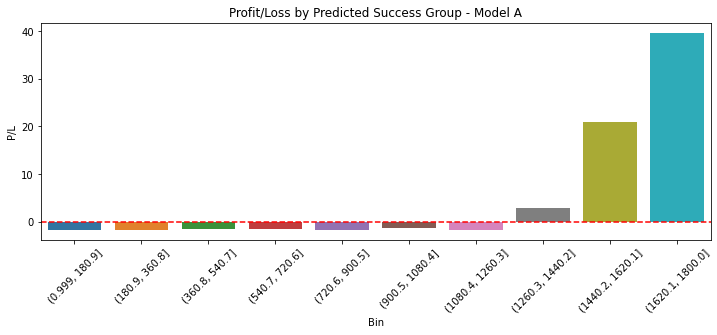

In [75]:
#plot the profit/loss by bin/group for Model A
plt.subplots(figsize=(12,4))
sns.barplot(data=df_grouped_data_A, x=df_grouped_data_A.index, y='P/L');
plt.gca().set_title('Profit/Loss by Predicted Success Group - Model A')
for label in plt.gca().get_xticklabels():
        label.set_rotation(45) 
        
#line to separate profit vs. loss
plt.gca().axhline(0, linestyle='--', color='red');

## Model B

In [76]:
#cut the dataframe into 10 equal sized buckets (based on Model A Predictions)
df_actual_pred['Bin'] = pd.qcut(df_actual_pred['Model_B_Prob'],10)

#group the data in order to inspect profit/loss for each bin/group
df_grouped_data_B = df_actual_pred.groupby('Bin').agg({'Actual':'sum', 'Model_B_Prob':'count'}) \
    .rename(columns={'Model_B_Prob':'Count', 'Actual':'Successes'})

#determine the cost of the emails and the value provided by the emails for each group/bin
df_grouped_data_B['Cost'] = df_grouped_data_B['Count'] * 0.01
df_grouped_data_B['Value'] = df_grouped_data_B['Successes'] * 0.25

#determine profit or loss for each group/bin
df_grouped_data_B['P/L'] = df_grouped_data_B['Value'] - df_grouped_data_B['Cost']

df_actual_pred.drop(columns='Bin', inplace=True)

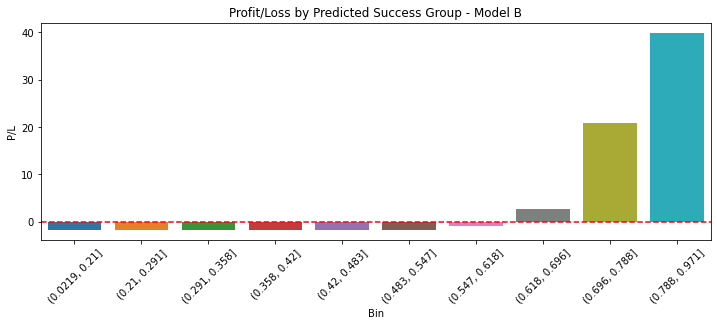

In [77]:
#plot the profit/loss by bin/group for Model B
plt.subplots(figsize=(12,4))
sns.barplot(data=df_grouped_data_B, x=df_grouped_data_B.index, y='P/L');
plt.gca().set_title('Profit/Loss by Predicted Success Group - Model B')
for label in plt.gca().get_xticklabels():
        label.set_rotation(45) 
        
#line to separate profit vs. loss
plt.gca().axhline(0, linestyle='--', color='red');

As expected, the groups with the highest predicted values (most likely to be a Success) provide the most value for both Model A and Model B. With both models, roughly the top 30% of predicted probabilities result in profitable email campaigns. We can now look at the profit associated with selecting the top 30% of predictions from each model.

## Model A vs. Model B

In [35]:
df_grouped_data_A

,Successes,Count,Cost,Value,P/L
Bin,,,,,
"(0.999, 180.9]",1,180,1.8,0.25,-1.55
"(180.9, 360.8]",0,180,1.8,0.00,-1.80
"(360.8, 540.7]",0,180,1.8,0.00,-1.80
"(540.7, 720.6]",0,180,1.8,0.00,-1.80
"(720.6, 900.5]",1,180,1.8,0.25,-1.55
"(900.5, 1080.4]",0,180,1.8,0.00,-1.80
"(1080.4, 1260.3]",3,180,1.8,0.75,-1.05
"(1260.3, 1440.2]",18,180,1.8,4.50,2.70
"(1440.2, 1620.1]",91,180,1.8,22.75,20.95


In [79]:
df_grouped_data_B

,Successes,Count,Cost,Value,P/L
Bin,,,,,
"(0.0219, 0.21]",0,180,1.8,0.00,-1.80
"(0.21, 0.291]",0,180,1.8,0.00,-1.80
"(0.291, 0.358]",0,180,1.8,0.00,-1.80
"(0.358, 0.42]",0,180,1.8,0.00,-1.80
"(0.42, 0.483]",0,180,1.8,0.00,-1.80
"(0.483, 0.547]",0,180,1.8,0.00,-1.80
"(0.547, 0.618]",4,180,1.8,1.00,-0.80
"(0.618, 0.696]",18,180,1.8,4.50,2.70
"(0.696, 0.788]",91,180,1.8,22.75,20.95


In [36]:
profit_A = df_grouped_data_A[df_grouped_data_A['P/L'] > 0]['P/L'].sum()
print('If we select the top 30% of predictions from Model A, the profit will be ${}'.format(profit_A))

If we select the top 30% of predictions from Model A, the profit will be $63.35


In [81]:
profit_B = df_grouped_data_B[df_grouped_data_B['P/L'] > 0]['P/L'].sum()
print('If we select the top 30% of predictions from Model B, the profit will be ${}'.format(profit_B))

If we select the top 30% of predictions from Model B, the profit will be $63.6


Model B actually had slighly higher profit. Therefore, we should stick with Model B as model A does not provide any additional value. The simplicity associated with Model B will likely result in a more robust model. With Model_B we should go forward with email campaigns where the predicted probability is 0.618 or higher.